# Solving Poisson's equation on topological domains
In this notebook, we will show how to solve poisson's equation on single patch and multipatch domains. As we are running this in a notebook, everything will be run in serial and hence we are limiting ourselves to a fairly coarse discretization to avoid taking too much time. However Psydac allows for hybrid MPI + OpenMP parallelization.  
The lines that can be changed to allow for MPI usage will be precedeed by their MPI using counterpart.

## Step 1 : Building the domain
Psydac uses the powerful topological tools of SymPDE to build a large variety of domains. Here we show how to do a quarter annulus using a Square and a polar mapping and how to join two annulus to create a multipatch domain. Left commented is an example of a complex multipatch domain built using SymPDE.

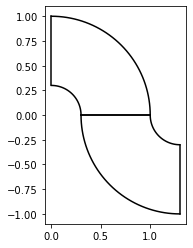

In [1]:
import numpy as np

from sympde.topology import Square, PolarMapping
from sympde.utilities.utils import plot_domain

from psydac.api.tests.build_domain import build_pretzel

# Define the topological geometry for each patch
rmin, rmax = 0.3, 1.

# First quarter annulus
domain_log_1 = Square('A_1', bounds1=(0., 1.), bounds2=(0., np.pi/2))
F_1 = PolarMapping('F_1', dim=2, c1=0., c2=0., rmin=rmin, rmax=rmax)
Omega_1 = F_1(domain_log_1)

# Second quarter annulus
domain_log_2 = Square('A_2', bounds1=(0., 1.), bounds2=(np.pi, 3/2 * np.pi))
F_2 = PolarMapping('F_1', dim=2, c1=rmin+rmax, c2=0., rmin=rmin, rmax=rmax)
Omega_2 = F_2(domain_log_2)

# Join the patches
Omega = Omega_1.join(Omega_2, 'Omega', 
                     bnd_minus=Omega_1.get_boundary(axis=1, ext=-1),
                     bnd_plus=Omega_2.get_boundary(axis=1, ext=-1),
)

# Example of a complex multi-patch domain
# Omega = build_pretzel()

# Simple visualization of the topological domain
plot_domain(Omega, draw=False)

## Step 2: Defining the Abstract PDE model using SymPDE

In [40]:
from sympde.calculus import grad, dot
from sympde.calculus import minus, plus

from sympde.expr.expr          import LinearForm, BilinearForm
from sympde.expr.expr          import integral              
from sympde.expr.expr          import Norm                       
from sympde.expr               import find, EssentialBC

from sympde.topology import ScalarFunctionSpace
from sympde.topology import elements_of
from sympde.topology import NormalVector

# Define the abstract model to solve Poisson's equation using the manufactured solution method
x,y       = Omega.coordinates
solution  = x**2 + y**2
f         = -4

V   = ScalarFunctionSpace('V', Omega, kind=None)

u, v = elements_of(V, names='u, v')
nn   = NormalVector('nn')

bc   = EssentialBC(u, solution, Omega.boundary)

error  = u - solution

I = Omega.interfaces

kappa  = 10**3

expr_I =- 0.5*dot(grad(plus(u)),nn)*minus(v)  + 0.5*dot(grad(minus(v)),nn)*plus(u)  - kappa*plus(u)*minus(v)\
        + 0.5*dot(grad(minus(u)),nn)*plus(v)  - 0.5*dot(grad(plus(v)),nn)*minus(u)  - kappa*plus(v)*minus(u)\
        - 0.5*dot(grad(minus(v)),nn)*minus(u) - 0.5*dot(grad(minus(u)),nn)*minus(v) + kappa*minus(u)*minus(v)\
        + 0.5*dot(grad(plus(v)),nn)*plus(u)   + 0.5*dot(grad(plus(u)),nn)*plus(v)   + kappa*plus(u)*plus(v)

expr   = dot(grad(u),grad(v))

a = BilinearForm((u,v),  integral(Omega, expr) + integral(I, expr_I))
l = LinearForm(v, integral(Omega, f*v))

equation = find(u, forall=v, lhs=a(u,v), rhs=l(v), bc=bc)

l2norm = Norm(error, Omega, kind='l2')
h1norm = Norm(error, Omega, kind='h1')

## Step 3: Discretizing the domain, spaces and equations

In [41]:
# Discretize the geometry and equation
from psydac.api.discretization import discretize
from psydac.api.settings import PSYDAC_BACKENDS

# The backends are as follows and can all be run with OpenMP by setting backend['omp'] = True.
# For all but the Python backend, compilation flags can be accessed and changed using backend['flags'].
# - Python backend: Generate and runs python files. Accessed via PSYDAC_BACKENDS['python']
# - Pyccel GCC backend: Accessed via PSYDAC_BACKENDS['pyccel-gcc']
# - Pyccel Intel backend: Accessed via PSYDAC_BACKENDS['pyccel-intel']
# - Pyccel PGI backend: Accessed via PSYDAC_BACKENDS['pyccel-pgi']
# - Pyccel Numba backend: Accessed via PSYDAC_BACKENDS['numba']

backend = PSYDAC_BACKENDS['python']

# Uncomment to use OpenMp
# import os
# os.environ['OMP_NUM_THREADS'] = "4"
# backend['omp'] = True

ncells = [10, 10]
degree = [2, 2]

# MPI version
# from mpi4py import MPI
# comm = MPI.COMM_WORLD
# Omega_h = discretize(Omega, ncells=ncells, comm=comm)
Omega_h = discretize(Omega, ncells=ncells)

Vh         = discretize(V, Omega_h, degree=degree, periodic=[False, False])
equation_h = discretize(equation, Omega_h, [Vh, Vh], backend=backend)
l2norm_h   = discretize(l2norm, Omega_h, Vh, backend=backend)
h1norm_h   = discretize(h1norm, Omega_h, Vh, backend=backend)

## Step 4: Solving the equation and computing the error norms

In [42]:
# Set the solver parameters
# 'cg' -> Conjugate gradient method
equation_h.set_solver('cg', info=True, tol=1e-14)

import time

t0_s     = time.time()
uh, info = equation_h.solve()
t1_s     = time.time()


t0_d     = time.time()
l2_error = l2norm_h.assemble(u=uh)
h1_error = h1norm_h.assemble(u=uh)
t1_d     = time.time()

print( '> CG info       :: ',info )
print( '> L2 error      :: {:.2e}'.format(l2_error))
print( '> H1 error      :: {:.2e}'.format(h1_error))
print( '> Solution time :: {:.2e}s'.format(t1_s - t0_s))
print( '> Evaluat. time :: {:.2e}s '.format(t1_d - t0_d))

> CG info       ::  {'niter': 109, 'success': True, 'res_norm': 5.704506834276634e-15}
> L2 error      :: 9.14e-02
> H1 error      :: 1.62e+00
> Solution time :: 1.42e+01s
> Evaluat. time :: 4.73e-01s 


## Step 5: Saving the results

In [43]:
# Save the results using OutputManager
from psydac.api.postprocessing import OutputManager
import os

os.makedirs('results_poisson', exist_ok=True)

Om = OutputManager(
    f'results_poisson/space_info_{Omega.name}',
    f'results_poisson/field_info_{Omega.name}',
# MPI version
#   comm=comm,    
)

Om.add_spaces(V=Vh)
Om.export_space_info()

Om.set_static()
Om.export_fields(u=uh)

Om.close()

## Step 6: Exporting the results to VTK and visualizing them with Paraview

In [44]:
# Export the results to VTK using PostProcessManager
from psydac.api.postprocessing import PostProcessManager
from sympy import lambdify

Pm = PostProcessManager(
    domain=Omega,
    space_file=f'results_poisson/space_info_{Omega.name}.yml',
    fields_file=f'results_poisson/field_info_{Omega.name}.h5',
# MPI version
#   comm=comm,    
)

Pm.export_to_vtk(
    f'results_poisson/visu_{Omega.name}',
    grid=None,
    npts_per_cell=3,
    fields='u',
    additional_physical_functions={'exact_solution': lambdify(Omega.coordinates, solution, modules='numpy')}
)

Pm.close()

### Example: Results on the pretzel domain

<p float="left">
  <img src="./paraview_images/poisson_pretzel_u.png" width="32%" />
  <img src="./paraview_images/poisson_pretzel_exact.png" width="32%" />
  <img src="./paraview_images/poisson_pretzel_error.png" width="32%" />
</p>